In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
# Importing Libraries

import pandas as pd
import numpy as np

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/activities.csv')

In [ ]:
df.head()

,Count,time,ax,ay,az,Activity,Subject
0,1,0.002587,1.4945,-0.7350,-1.1442,Upstairs,0
1,2,0.003146,1.5047,-0.7142,-1.2787,Upstairs,0
2,3,0.003516,1.4692,-0.7034,-1.4197,Upstairs,0
3,4,0.003925,1.4416,-0.6778,-1.5029,Upstairs,0
4,5,0.004144,1.3632,-0.6229,-1.6225,Upstairs,0


In [ ]:
df.tail()

,Count,time,ax,ay,az,Activity,Subject
10207,10208,4.983669,0.0024,0.0089,-0.0261,Laying,3
10208,10209,4.985108,-0.0124,-0.0080,-0.0283,Laying,3
10209,10210,4.988110,-0.0073,0.0019,-0.0332,Laying,3
10210,10211,4.991234,-0.0049,0.0072,-0.0262,Laying,3
10211,10212,4.993363,-0.0162,-0.0073,-0.0383,Laying,3


In [ ]:

df.drop(df.columns[[0, 1]], axis=1, inplace=True)

In [ ]:

df.head()

,ax,ay,az,Activity,Subject
0,1.4945,-0.7350,-1.1442,Upstairs,0
1,1.5047,-0.7142,-1.2787,Upstairs,0
2,1.4692,-0.7034,-1.4197,Upstairs,0
3,1.4416,-0.6778,-1.5029,Upstairs,0
4,1.3632,-0.6229,-1.6225,Upstairs,0


In [ ]:
# Activities are the class labels
Activity = {
    0: 'Upstairs',
    1:'Sitting',
    2:'Downstairs',
    3:'Laying'
}

In [ ]:
Activity

{0: 'Upstairs', 1: 'Sitting', 2: 'Downstairs', 3: 'Laying'}

# Loading Data / Making Data


In [ ]:
# Data directory
DATADIR = 'dataset'
SIGNALS = [
    "ax",
    "ay",
    "az"
    ]

1. These are Raw data signals which are given in Inertial Signals form.
2. Signals are taken from sensors (Accelerometer and Gyroscope).
3. The signals are in x,y,z directions that is 3-axial linear acceleration and 3-axial angular velocity.
4. Sensor signals are filtered to have only body acceleration.
5. Triaxial acceleration from the accelerometer is total acceleration.

In [ ]:
df

,ax,ay,az,Activity,Subject
0,1.4945,-0.7350,-1.1442,Upstairs,0
1,1.5047,-0.7142,-1.2787,Upstairs,0
2,1.4692,-0.7034,-1.4197,Upstairs,0
3,1.4416,-0.6778,-1.5029,Upstairs,0
4,1.3632,-0.6229,-1.6225,Upstairs,0
...,...,...,...,...,...
10207,0.0024,0.0089,-0.0261,Laying,3
10208,-0.0124,-0.0080,-0.0283,Laying,3
10209,-0.0073,0.0019,-0.0332,Laying,3
10210,-0.0049,0.0072,-0.0262,Laying,3


In [ ]:
X = df.iloc[:,0:3].values
y = df.iloc[:,4:].values

In [ ]:
print(X)


[[ 1.4945 -0.735  -1.1442]
 [ 1.5047 -0.7142 -1.2787]
 [ 1.4692 -0.7034 -1.4197]
 ...
 [-0.0073  0.0019 -0.0332]
 [-0.0049  0.0072 -0.0262]
 [-0.0162 -0.0073 -0.0383]]


In [ ]:
print(y)

[[0]
 [0]
 [0]
 ...
 [3]
 [3]
 [3]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(y).reshape(-1,1))

In [ ]:
df1 # Changed to an array---- Values are b/wn 0-1

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size


train_data =df1[0:training_size,:]
test_data  = df1[training_size:len(df1),:1]

In [ ]:
train_data.shape 

(7148, 1)

In [ ]:
test_data.shape

(3064, 1)

In [ ]:
import numpy

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train.shape

(7047, 100)

In [ ]:
y_train.shape

(7047,)

In [ ]:
X_test.shape

(2963, 100)

In [ ]:
y_test.shape

(2963,)

In [ ]:
# As we know that for LSTM we need to give data in the form of 3 dimensions:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
X_train.shape 

(7047, 100, 1)

In [ ]:
# ### Create the Stacked LSTM model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1,activation='sigmoid'))
# model.compile(loss='mean_squared_error',optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
111/111 [==============================] - 12s 26ms/step - loss: 0.0000e+00 - accuracy: 0.8421 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
111/111 [==============================] - 2s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8421 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/100
111/111 [==============================] - 2s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8421 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/100
111/111 [==============================] - 2s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8421 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/100
111/111 [==============================] - 2s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8421 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/100
111/111 [==============================] - 2s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8421 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/100
111/111 [==============================] - 2s 18ms/

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

93/93 [==============================] - 1s 7ms/step


In [ ]:
##Transformback to original form as it was initially b/wn 0-1
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.13247203006427283

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

0.7263476476444903

In [ ]:
import matplotlib.pyplot as plt

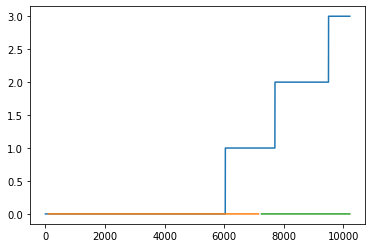

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)  # No of records/values in the test_data

3064

In [ ]:
x_input=test_data[278:].reshape(1,-1)
x_input.shape

(1, 2786)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input # It has 100 values 

[0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333

In [ ]:
y_test, model.predict(X_test)

93/93 [==============================] - 1s 7ms/step


(array([0.33333333, 0.33333333, 0.33333333, ..., 1.        , 1.        ,
        1.        ]), array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32))